In [3]:
!pip install pandas-gbq

In [2]:
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns
from datetime import datetime as dt
matplotlib.use('Agg')
matplotlib.style.use('ggplot')
%matplotlib inline


### Fetching data of 1% of users in the dataset

In [3]:
experiment = 'temporal_static'
dsname = '56_30d'
share = 100                

query = """SELECT f.*, u.churn, u.days_since_registration,
u.reporting_country, CASE when product IN ('free','employee', 'non-cc-trial') THEN 'free'
    ELSE 'direct' end as product_type
FROM `user-lifecycle.helderm.features_{exp}_{ds}_e` f
JOIN `user-lifecycle.helderm.users_{exp}_{ds}` u
ON f.user_id=u.user_id
WHERE MOD(ABS(FARM_FINGERPRINT(MD5(u.user_id))), {share}) = 0
""".format(exp=experiment, ds=dsname, share=share)
df = pd.read_gbq(query, 'user-lifecycle', dialect='standard')

Requesting query... ok.
Query running...
Query done.
Cache hit.

Retrieving results...
  Got page: 2; 1.0% done. Elapsed 12.84 s.
  Got page: 3; 2.0% done. Elapsed 19.55 s.
  Got page: 4; 3.0% done. Elapsed 25.88 s.
  Got page: 5; 3.0% done. Elapsed 31.93 s.
  Got page: 6; 4.0% done. Elapsed 38.71 s.
  Got page: 7; 4.0% done. Elapsed 44.16 s.
  Got page: 8; 5.0% done. Elapsed 50.98 s.
  Got page: 9; 6.0% done. Elapsed 56.16 s.
  Got page: 10; 6.0% done. Elapsed 60.65 s.
  Got page: 11; 7.0% done. Elapsed 66.02 s.
  Got page: 12; 8.0% done. Elapsed 71.11 s.
  Got page: 13; 8.0% done. Elapsed 77.01 s.
  Got page: 14; 9.0% done. Elapsed 83.51 s.
  Got page: 15; 10.0% done. Elapsed 88.69 s.
  Got page: 16; 10.0% done. Elapsed 94.87 s.
  Got page: 17; 11.0% done. Elapsed 99.73 s.
  Got page: 18; 11.0% done. Elapsed 106.4 s.
  Got page: 19; 12.0% done. Elapsed 111.4 s.
  Got page: 20; 13.0% done. Elapsed 116.5 s.
  Got page: 21; 13.0% done. Elapsed 122.32 s.
  Got page: 22; 14.0% done. Elaps

### Setting some args up for plotting

In [4]:
# filter out users that changed countries during sampling period
df = df[df.reporting_country.isin(['BR','MX','US'])]

# filter out days where the samples were taken
#acttimesplits = 9
#df = df[df.time.isin(sorted(df.time.unique())[:-acttimesplits])]

# set some plotting vars
ci = 95
cmap = sns.diverging_palette(220, 10, as_cmap=True)
palette = sns.color_palette("Set2", 10)
sns.set_palette(palette)

font = {'weight' : 'normal',
        'size'   : 14}
matplotlib.rc('font', **font)
sns.set_style('whitegrid')

# date formatter for time series x ticks
def myFormatter(x, pos):
    return pd.to_datetime(dt.fromtimestamp(x))


In [8]:
df['churn'] = pd.Categorical.from_codes(df['churn'], ['No', 'Yes'])

### Masking some feature names for the thesis report

In [59]:

'''new_cols = {}
for col in df.columns:
  new_col = col.replace('secs_played', 'consumption_time')
  new_col = new_col.replace('playlist', 'content')
  new_col = new_col.replace('charts', 'popular')
  new_col = new_col.replace('radio', 'context1')
  new_col = new_col.replace('running', 'context2')
  new_col = new_col.replace('mix', 'context3')
  new_col = new_col.replace('soundsof', 'context4')
  new_col = new_col.replace('top_types', 'contexts')
  new_col = new_col.replace('collection', 'context5')
  new_cols[col] = new_col
  
#print(new_cols)
df = df.rename(columns=new_cols)'''

### Creating some auxilary dataframes

In [10]:
df_churn = df[df.churn == 1]
df_nobf = df[df.backfill == False]
df_newus = df[df.days_since_registration < 74]

## Some basic info about our users

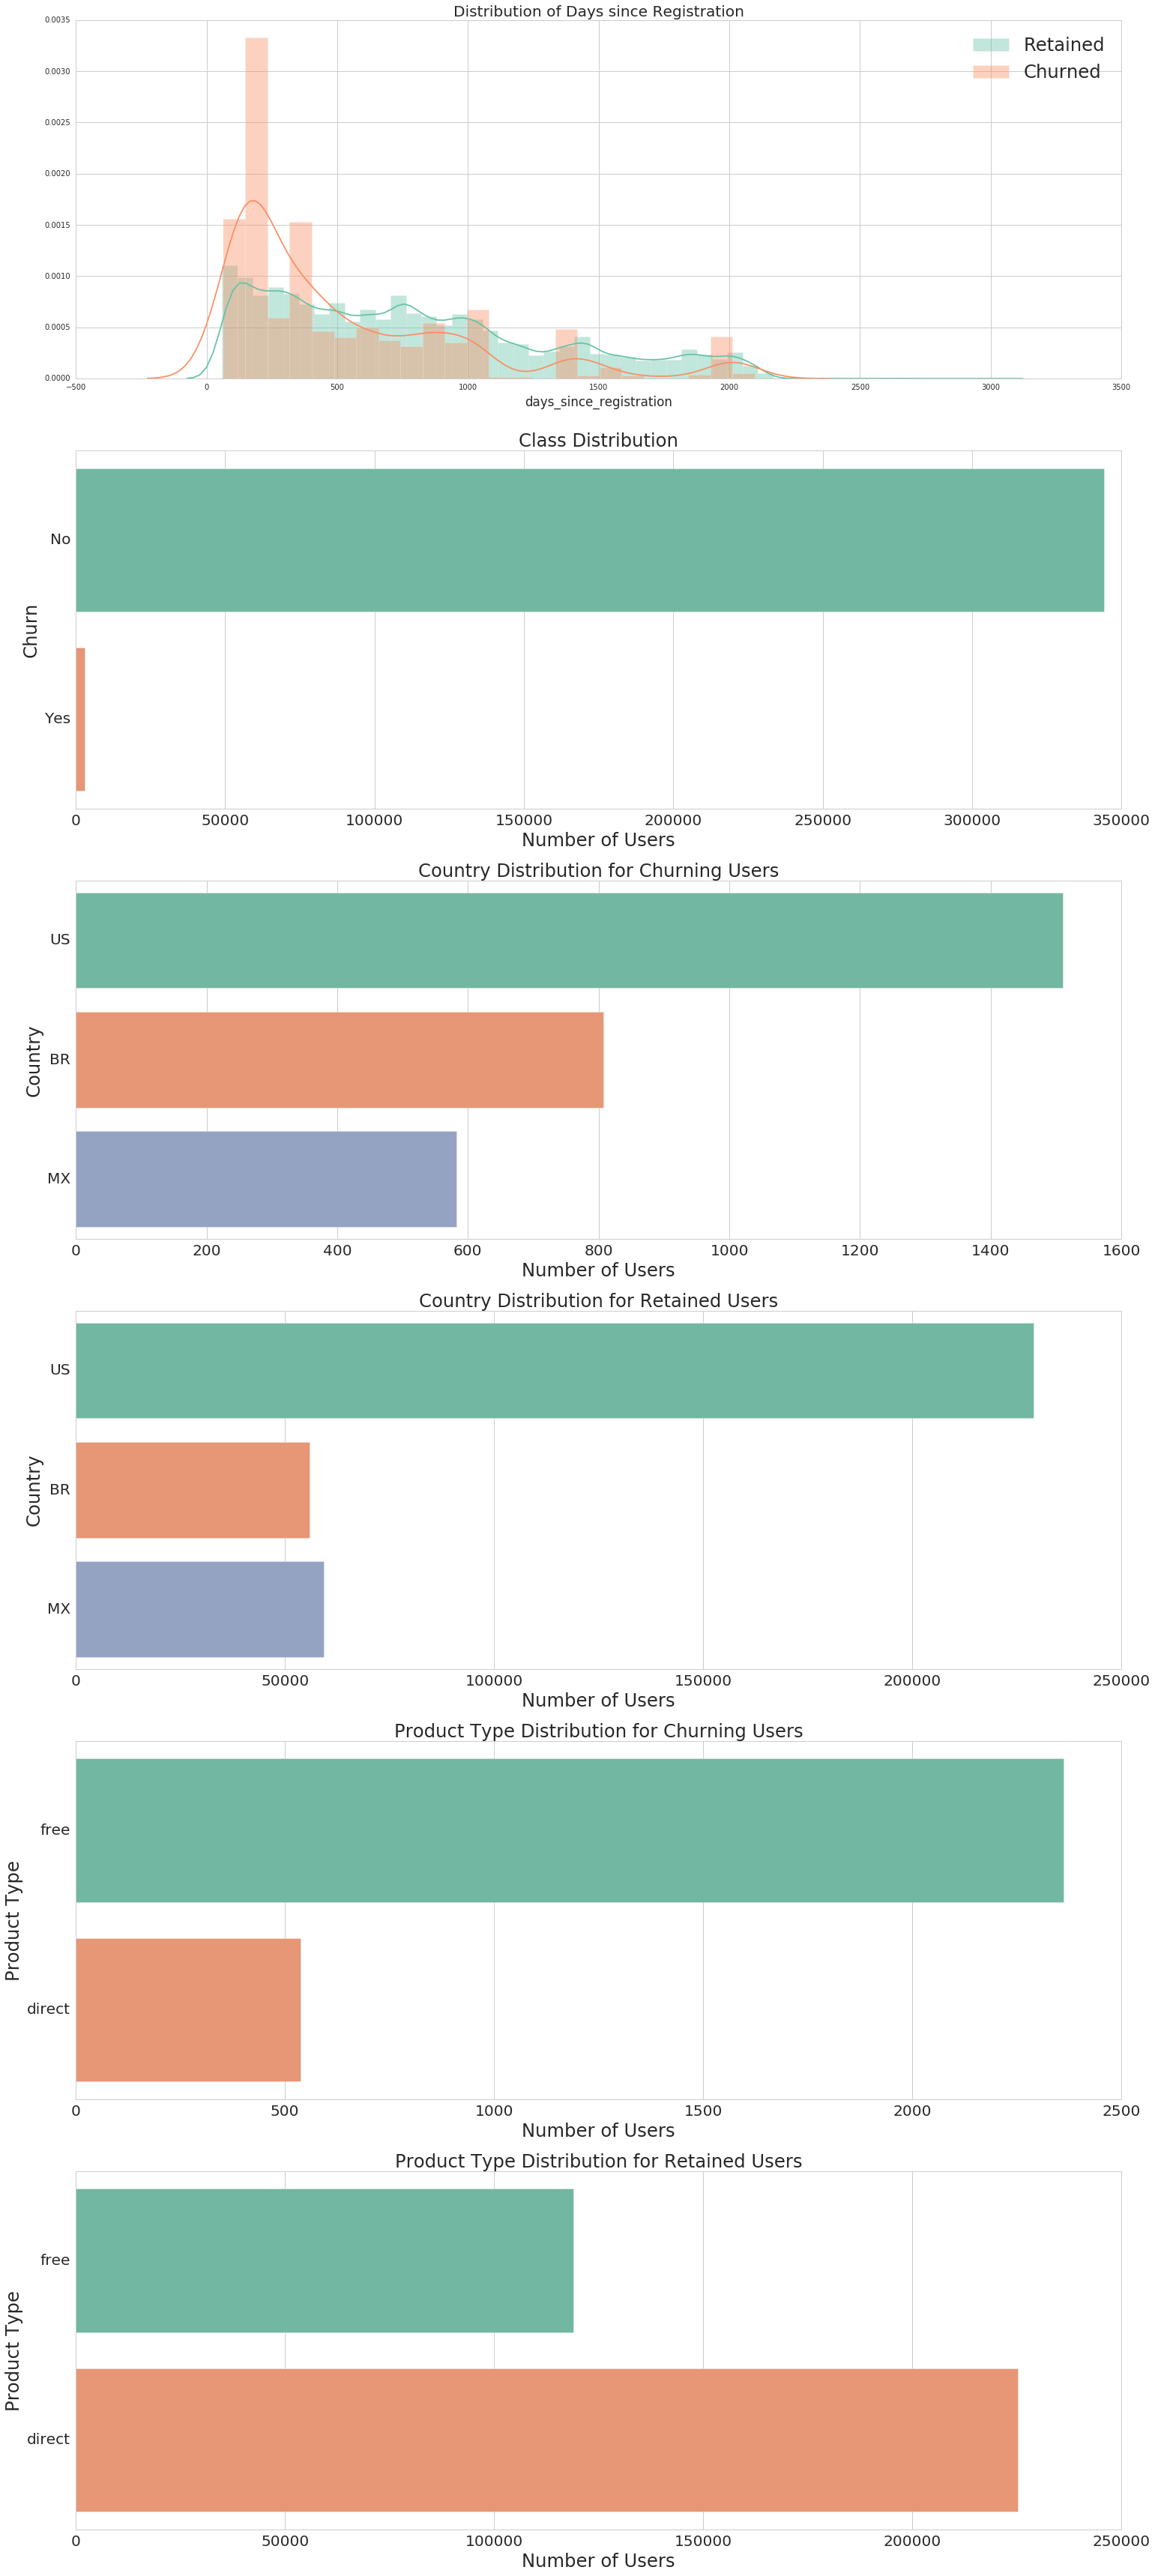

In [13]:
fig, axs = plt.subplots(nrows=6, figsize=(25,60))
sns.distplot(df_nobf[df_nobf.churn=='No'].days_since_registration, ax=axs[0], color=sns.color_palette(palette)[0])
sns.distplot(df_nobf[df_nobf.churn=='Yes'].days_since_registration, ax=axs[0], color=sns.color_palette(palette)[1])
axs[0].set_title('Distribution of Days since Registration')
axs[0].legend(['Retained', 'Churned'], fontsize='xx-large')

sns.countplot(data=df_nobf, y='churn', ax=axs[1], palette=palette)
axs[1].set_title('Class Distribution', fontsize='xx-large')
axs[1].set_xlabel('Number of Users', fontsize='xx-large')
axs[1].set_ylabel('Churn', fontsize='xx-large')
#axs[1].set_xticks([])
axs[1].tick_params(labelsize='x-large')
#plt.savefig('class_dist.pdf', bbox_inches='tight')
#!gsutil cp 'class_dist.pdf' 'gs://helder/churnr/plots/class_dist.pdf'

sns.countplot(data=df_nobf[df_nobf.churn=='Yes'], y='reporting_country', ax=axs[2], order=['US', 'BR', 'MX'])
axs[2].set_title('Country Distribution for Churning Users', fontsize='xx-large')
axs[2].set_xlabel('Number of Users', fontsize='xx-large')
axs[2].set_ylabel('Country', fontsize='xx-large')
#axs[2].set_xticks([])
axs[2].tick_params(labelsize='x-large')

sns.countplot(data=df_nobf[df_nobf.churn=='No'], y='reporting_country', ax=axs[3], order=['US', 'BR', 'MX'])
axs[3].set_title('Country Distribution for Retained Users', fontsize='xx-large')
axs[3].set_xlabel('Number of Users', fontsize='xx-large')
axs[3].set_ylabel('Country', fontsize='xx-large')
#axs[3].set_xticks([])
axs[3].tick_params(labelsize='x-large')
#plt.savefig('dist_reporting_country.pdf', bbox_inches='tight')
#!gsutil cp 'dist_reporting_country.pdf' 'gs://helder/churnr/plots/dist_reporting_country.pdf'

sns.countplot(data=df_nobf[df_nobf.churn=='Yes'], y='product_type', ax=axs[4], order=['free', 'direct'])
axs[4].set_title('Product Type Distribution for Churning Users', fontsize='xx-large')
axs[4].set_xlabel('Number of Users', fontsize='xx-large')
axs[4].set_ylabel('Product Type', fontsize='xx-large')
#axs[4].set_xticks([])
axs[4].tick_params(labelsize='x-large')

sns.countplot(data=df_nobf[df_nobf.churn=='No'], y='product_type', ax=axs[5], order=['free', 'direct'])
axs[5].set_title('Product Type Distribution for Retained Users', fontsize='xx-large')
axs[5].set_xlabel('Number of Users', fontsize='xx-large')
axs[5].set_ylabel('Product Type', fontsize='xx-large')
#axs[5].set_xticks([])
axs[5].tick_params(labelsize='x-large')

#plt.savefig('days_since_reg.pdf', bbox_inches='tight')
#!gsutil cp 'days_since_reg.pdf' 'gs://helder/churnr/plots/days_since_reg.pdf'

## Overall feature types vs. churn

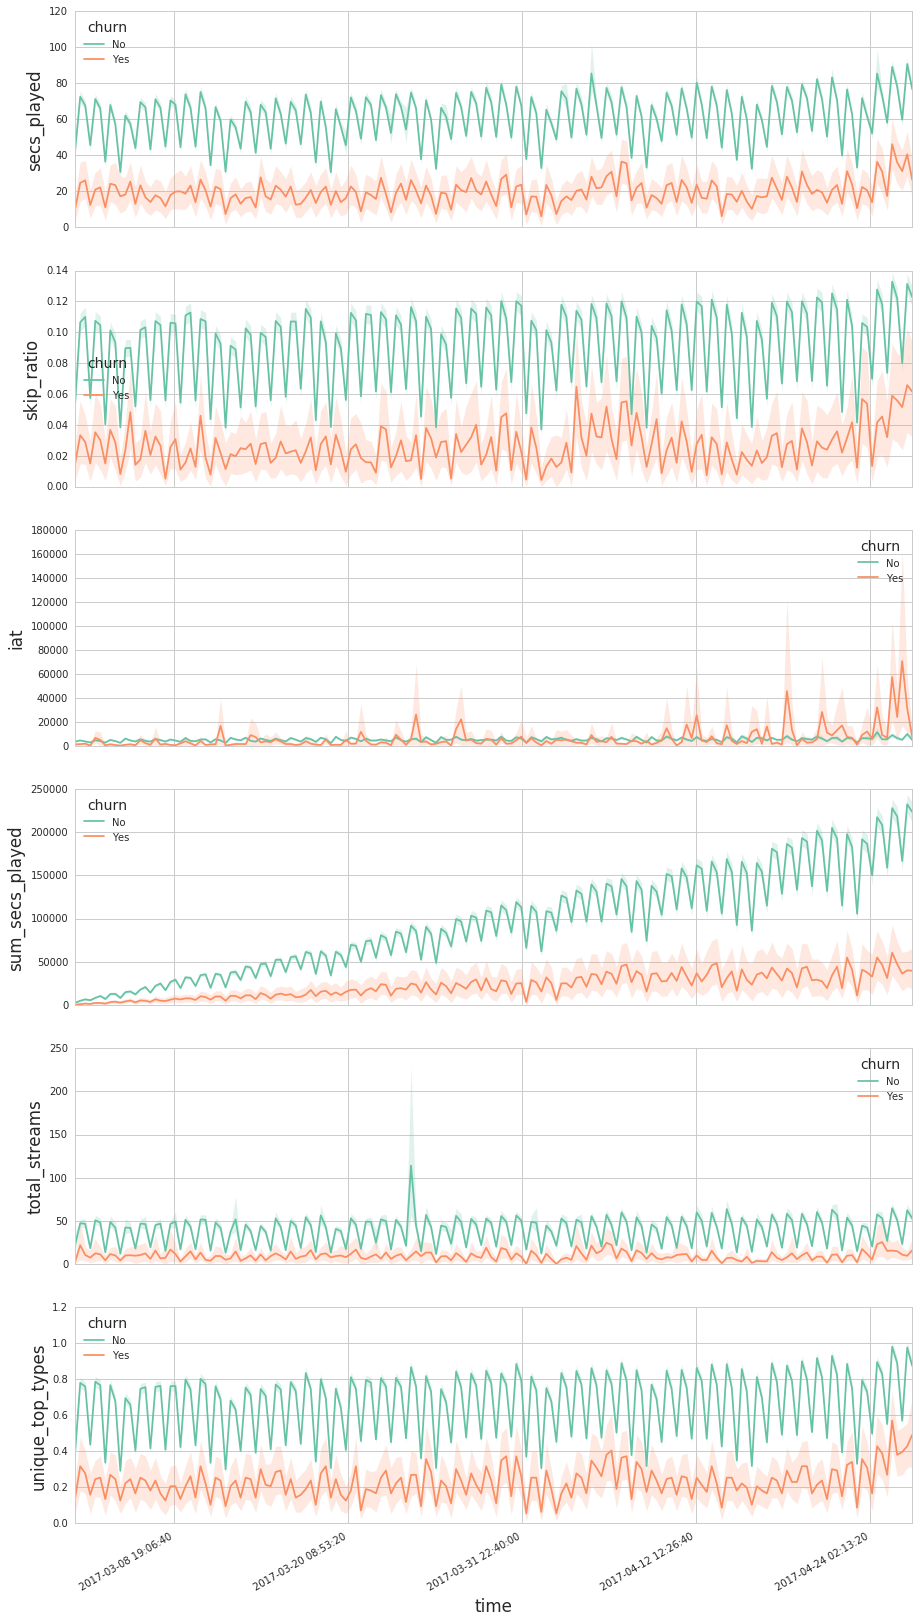

In [18]:
fig, axs = plt.subplots(nrows=6, figsize=(15,30))
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played',
              color=palette, ax=axs[0], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='skip_ratio',
              color=palette, ax=axs[1], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='iat',
              color=palette, ax=axs[2], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played',
              color=palette, ax=axs[3], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams',
              color=palette, ax=axs[4], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='unique_top_types',
              color=palette, ax=axs[5], ci=ci)
for ax in axs:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))
    #ax.set_yticks([])
    
fig.autofmt_xdate()

#plt.savefig('feats_time.pdf', bbox_inches='tight')
#!gsutil cp 'feats_time.pdf' 'gs://helder/churnr/plots/feats_time.pdf'

## Seconds played over different top types vs. Churn

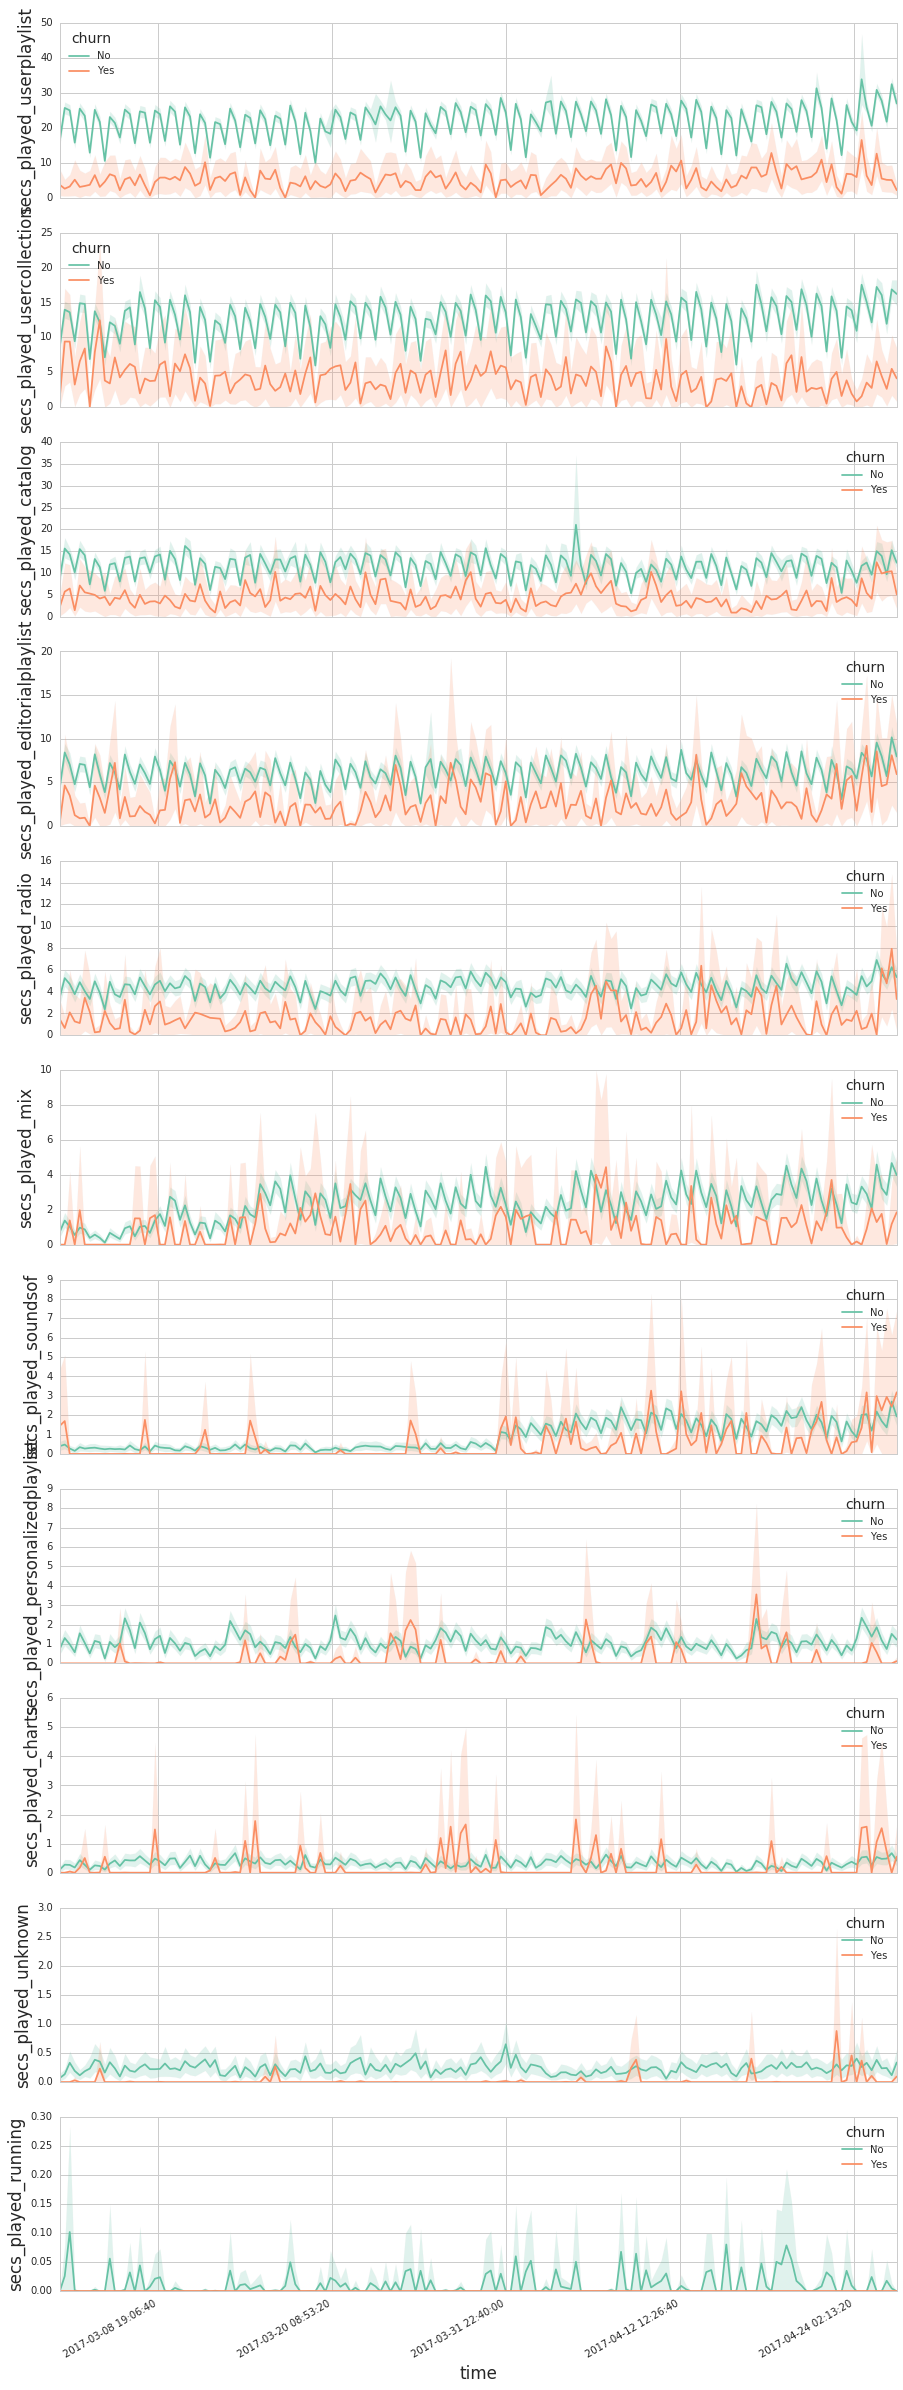

In [19]:
fig, axs = plt.subplots(nrows=11, figsize=(15,45))
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_userplaylist',
              color=palette, ax=axs[0], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_usercollection',
              color=palette, ax=axs[1], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_catalog',
              color=palette, ax=axs[2], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_editorialplaylist',
              color=palette, ax=axs[3], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_radio',
              color=palette, ax=axs[4], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_mix',
              color=palette, ax=axs[5], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_soundsof',
              color=palette, ax=axs[6], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_personalizedplaylist',
              color=palette, ax=axs[7], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_charts',
              color=palette, ax=axs[8], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_unknown',
              color=palette, ax=axs[9], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='secs_played_running',
              color=palette, ax=axs[10], ci=ci)

for ax in axs:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))
    
fig.autofmt_xdate()

## Total streams per top type vs. Churn

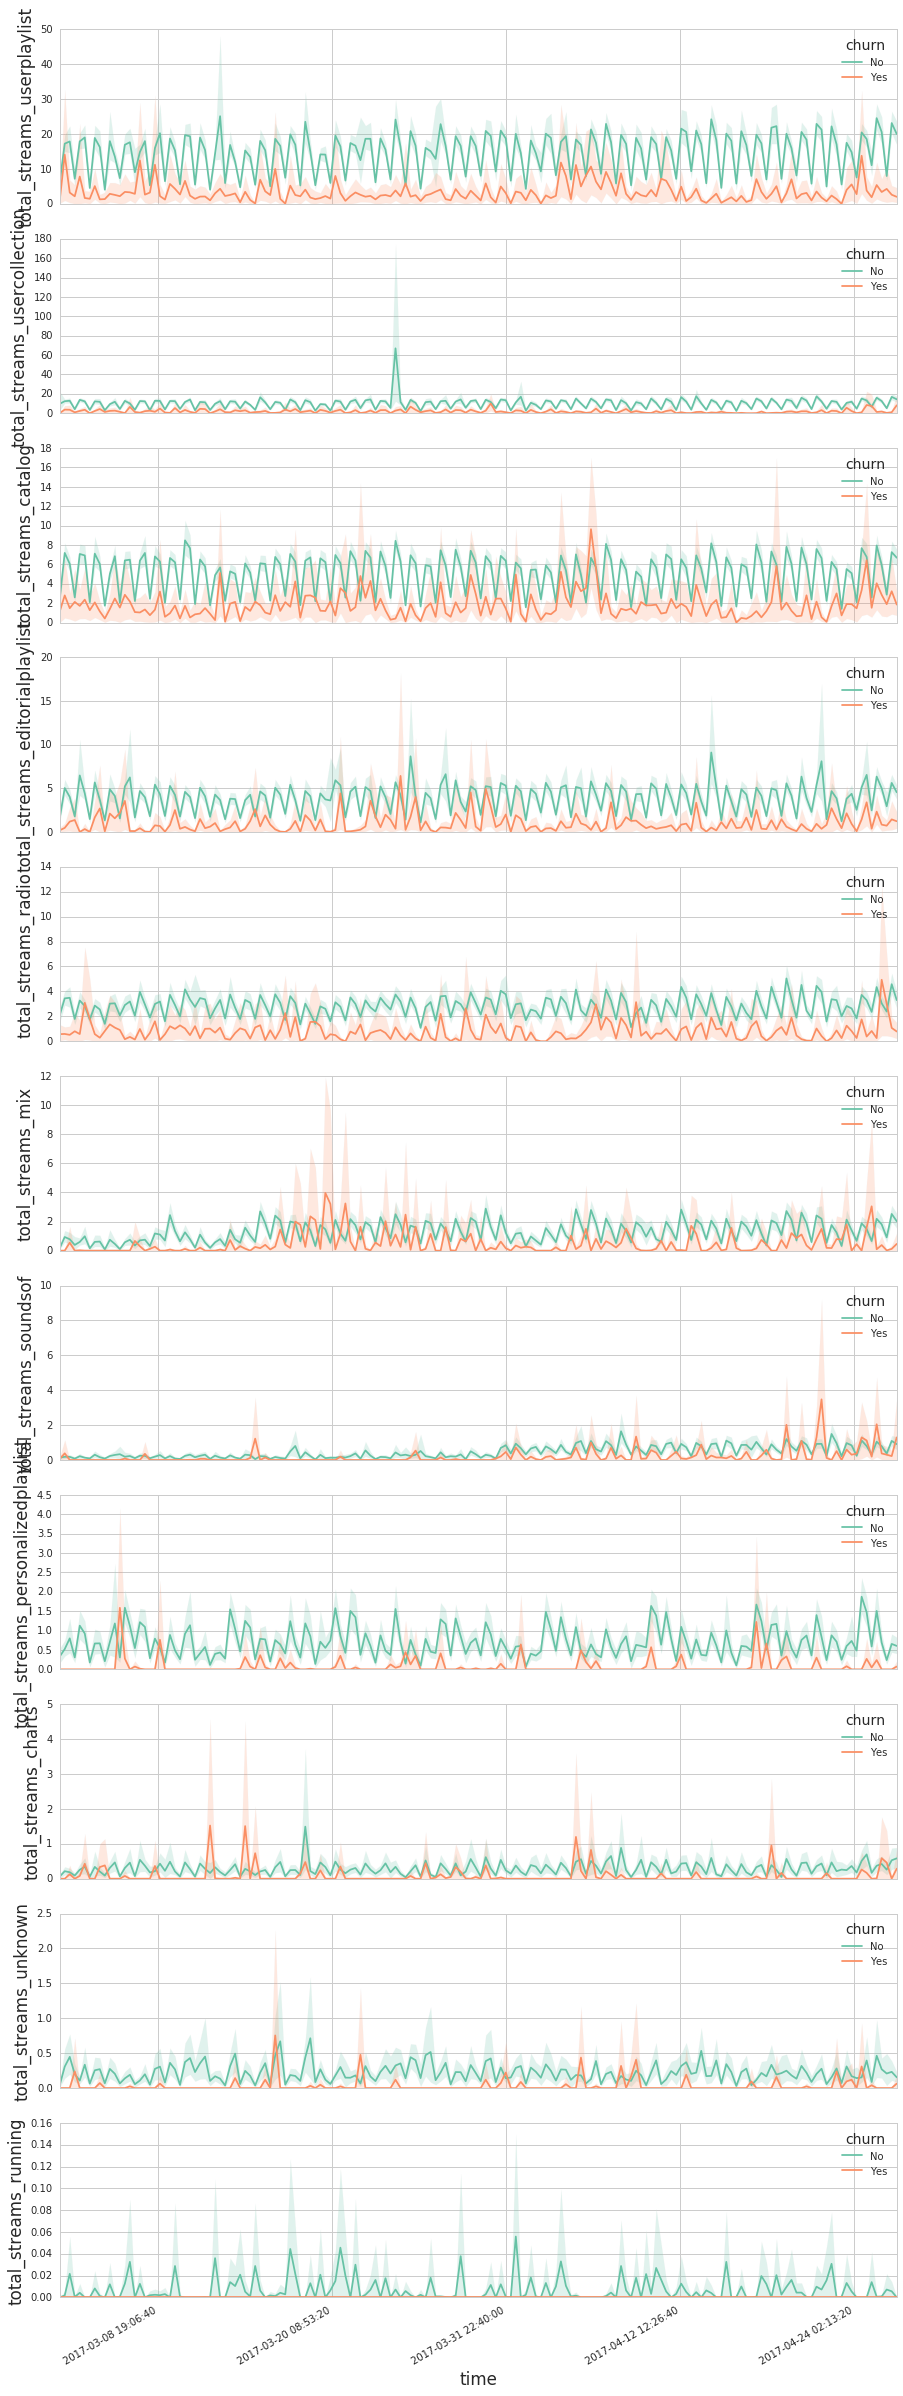

In [20]:
fig, axs = plt.subplots(nrows=11, figsize=(15,45))
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_userplaylist',
              color=palette, ax=axs[0], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_usercollection',
              color=palette, ax=axs[1], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_catalog',
              color=palette, ax=axs[2], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_editorialplaylist',
              color=palette, ax=axs[3], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_radio',
              color=palette, ax=axs[4], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_mix',
              color=palette, ax=axs[5], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_soundsof',
              color=palette, ax=axs[6], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_personalizedplaylist',
              color=palette, ax=axs[7], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_charts',
              color=palette, ax=axs[8], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_unknown',
              color=palette, ax=axs[9], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='total_streams_running',
              color=palette, ax=axs[10], ci=ci)

for ax in axs:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))
    
fig.autofmt_xdate()

## Sum secs played per top type vs. Churn

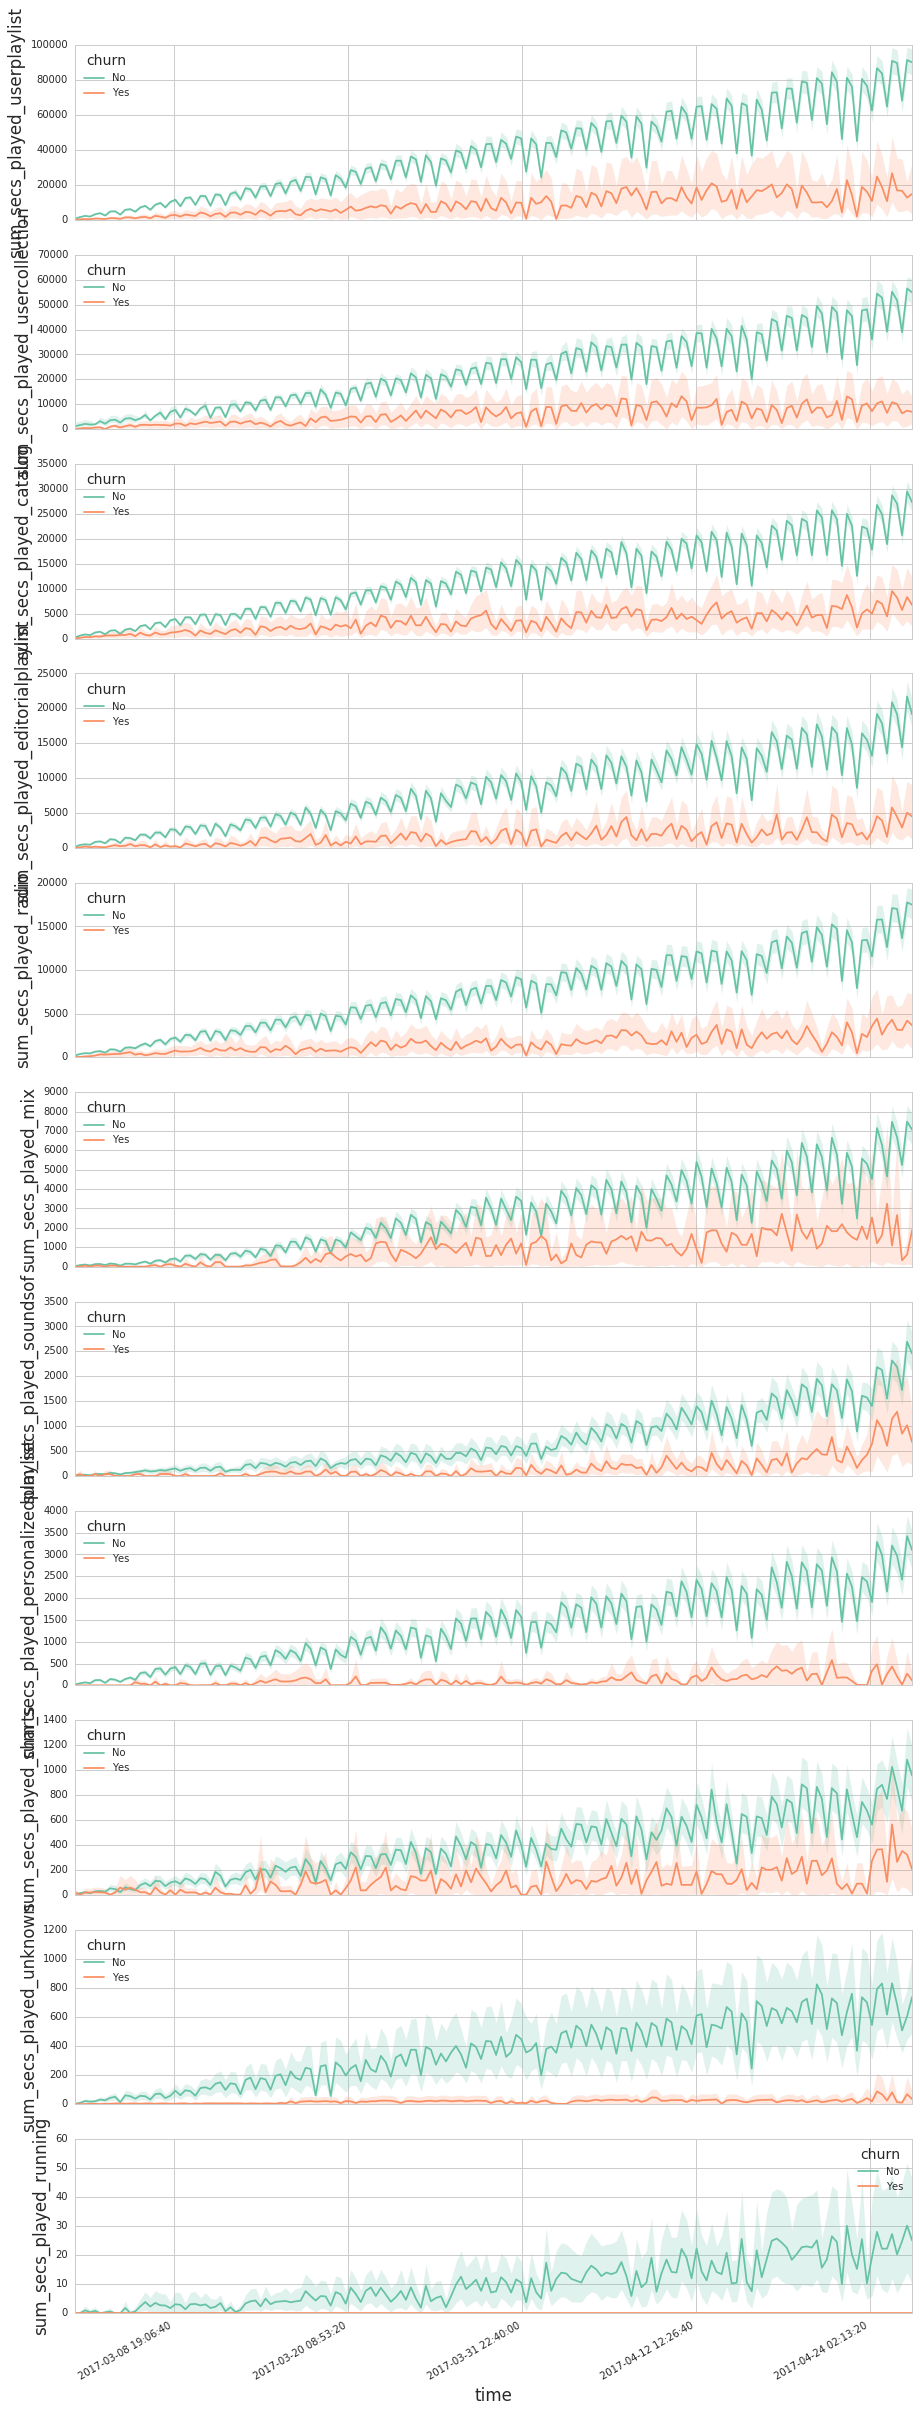

In [21]:
fig, axs = plt.subplots(nrows=11, figsize=(15,45))
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_userplaylist',
              color=palette, ax=axs[0], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_usercollection',
              color=palette, ax=axs[1], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_catalog',
              color=palette, ax=axs[2], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_editorialplaylist',
              color=palette, ax=axs[3], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_radio',
              color=palette, ax=axs[4], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_mix',
              color=palette, ax=axs[5], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_soundsof',
              color=palette, ax=axs[6], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_personalizedplaylist',
              color=palette, ax=axs[7], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_charts',
              color=palette, ax=axs[8], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_unknown',
              color=palette, ax=axs[9], ci=ci)
sns.tsplot(df, time='time', condition='churn', unit='user_id', value='sum_secs_played_running',
              color=palette, ax=axs[10], ci=ci)

for ax in axs:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))
    
fig.autofmt_xdate()

## Behaviour of new users (< 2 weeks) vs. Churn

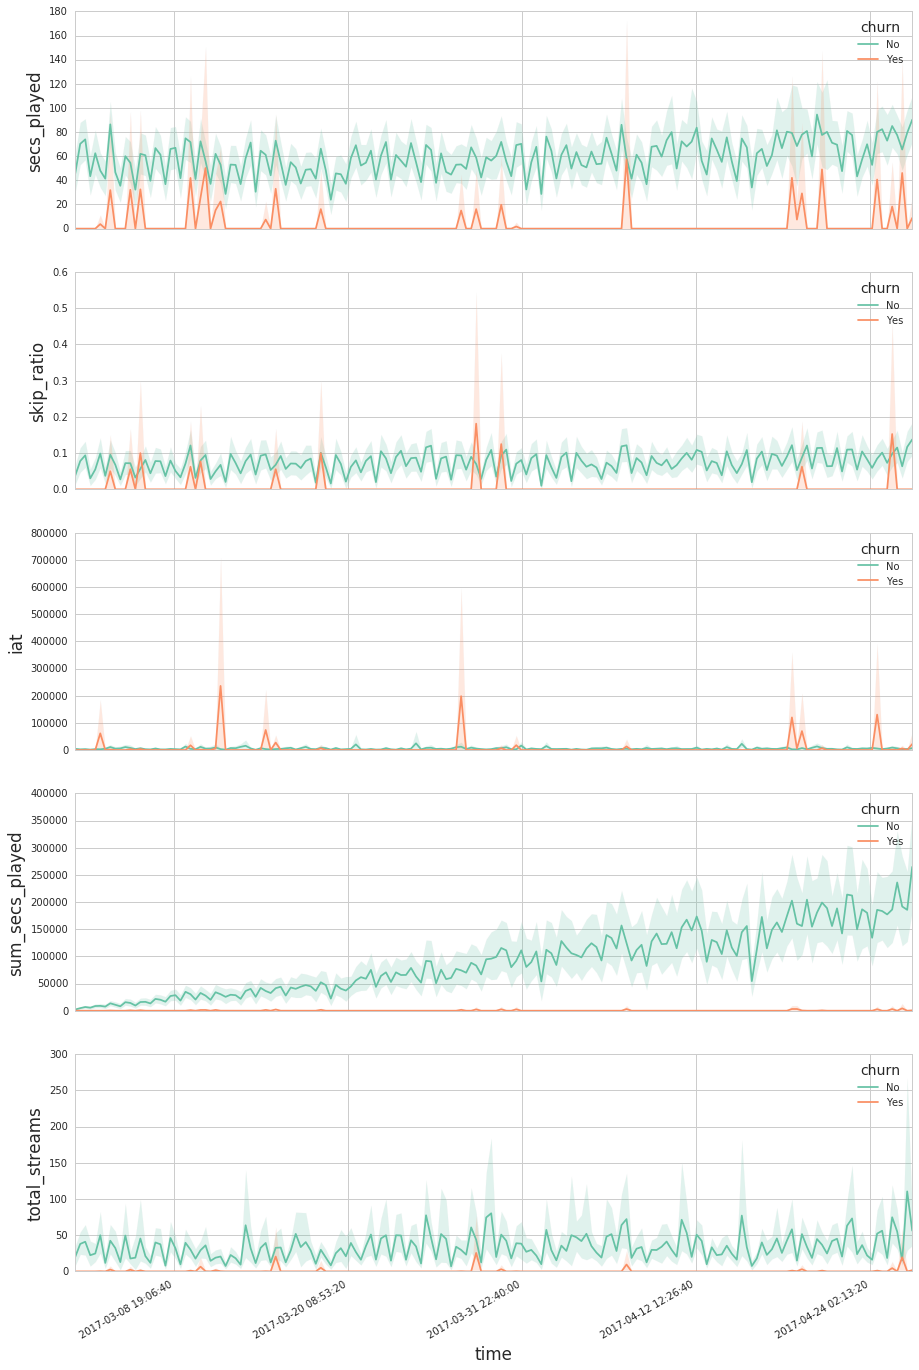

In [22]:
fig, axs = plt.subplots(nrows=5, figsize=(15,25))

sns.tsplot(df_newus, time='time', condition='churn', unit='user_id', value='secs_played',
              color=palette, ax=axs[0], ci=ci)
sns.tsplot(df_newus, time='time', condition='churn', unit='user_id', value='skip_ratio',
              color=palette, ax=axs[1], ci=ci)
sns.tsplot(df_newus, time='time', condition='churn', unit='user_id', value='iat',
              color=palette, ax=axs[2], ci=ci)
sns.tsplot(df_newus, time='time', condition='churn', unit='user_id', value='sum_secs_played',
              color=palette, ax=axs[3], ci=ci)
sns.tsplot(df_newus, time='time', condition='churn', unit='user_id', value='total_streams',
              color=palette, ax=axs[4], ci=ci)
for ax in axs:
    ax.xaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(myFormatter))
    
fig.autofmt_xdate()

## How these features correlate with each other?

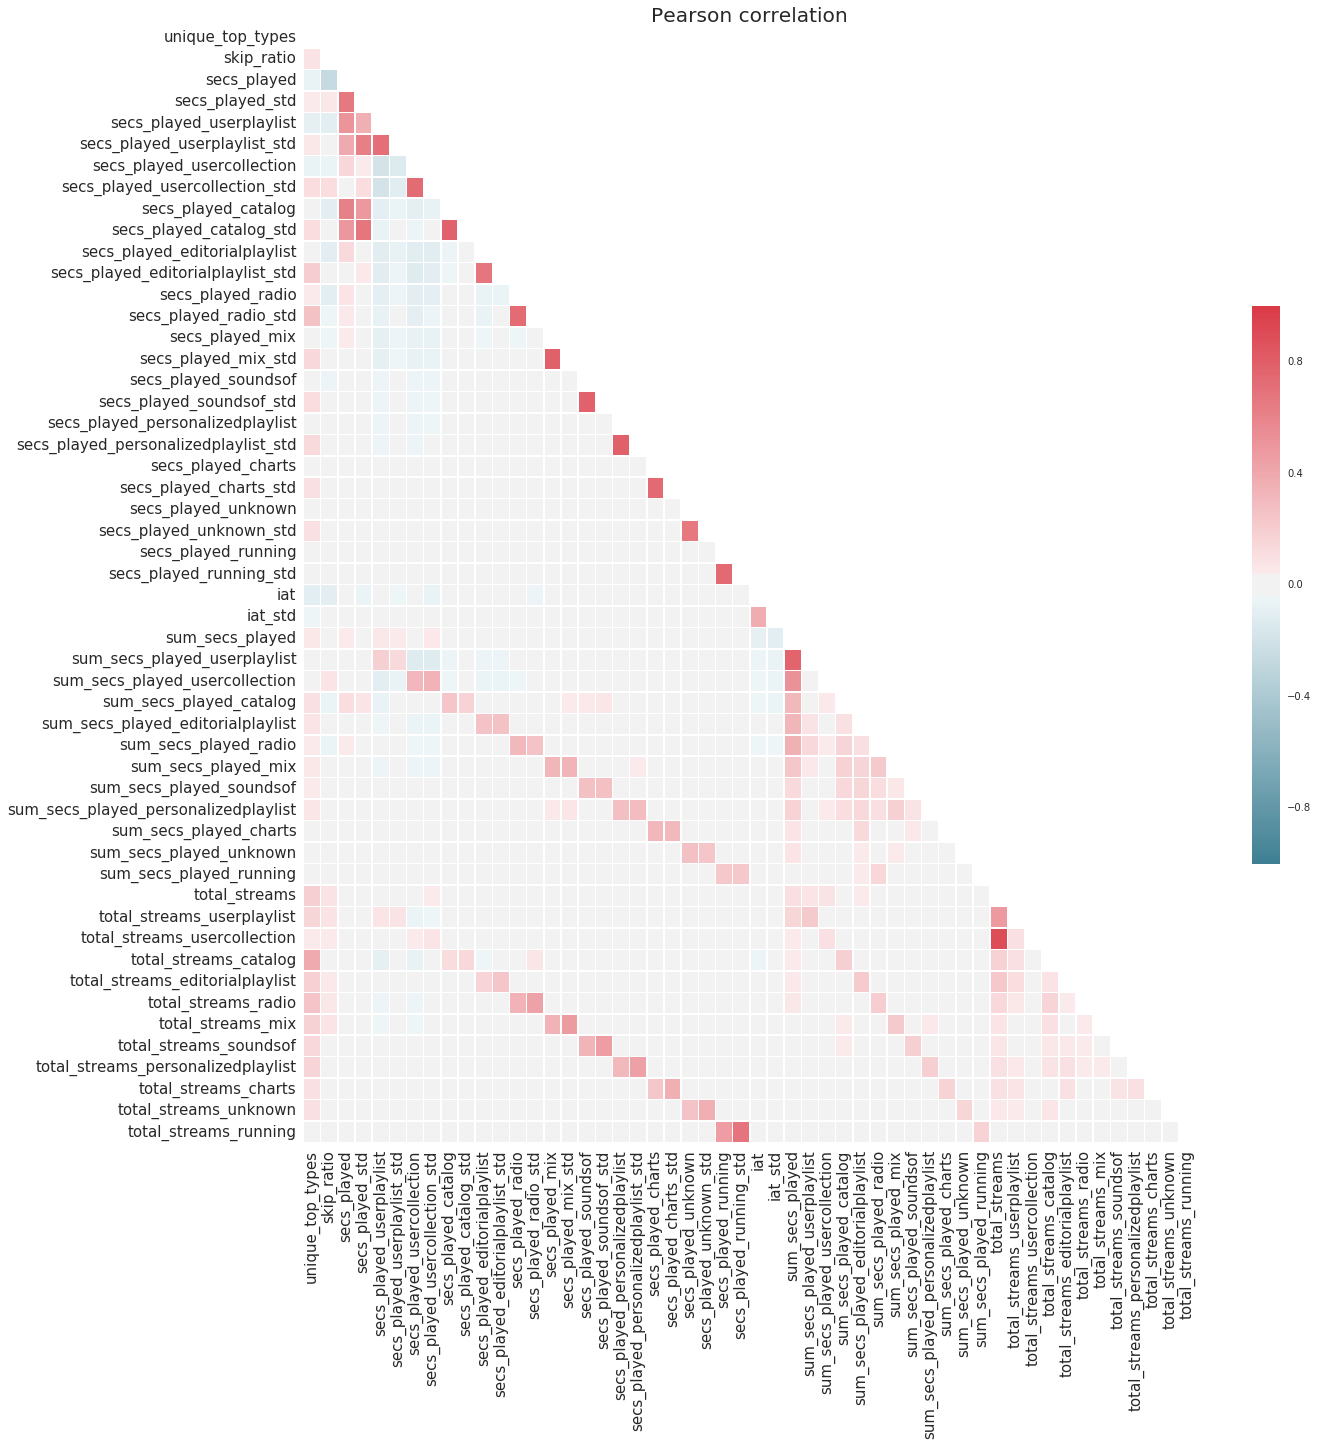

In [24]:
no_features = ['time', 'user_id', 'backfill', 'days_since_registration', 'reporting_country', 'product_type', 'latitude', 'longitude', 'churn']
corr = df_nobf[[f for f in df_nobf.columns if f not in no_features]].corr(method='pearson')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.title('Pearson correlation')
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)

#plt.savefig('corr.pdf', bbox_inches='tight')
#!gsutil cp 'corr.pdf' 'gs://helder/churnr/plots/corr.pdf'

## How these features correlate to churn?

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


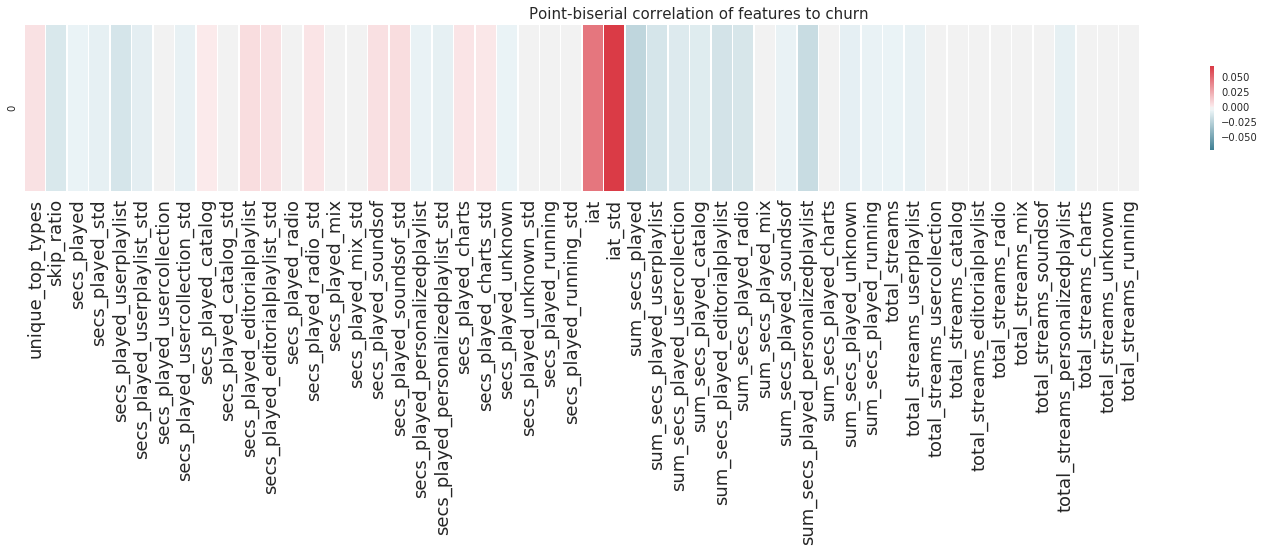

In [26]:
from scipy import stats
features = [f for f in df_nobf.columns if f not in ['time', 'user_id', 'backfill', 'days_since_registration', 
                'reporting_country', 'product_type', 'latitude', 'longitude', 'churn', 'platform', 'client_type', 'top_type']]
pbs =[]

df_nobf['churn'] = np.where(df_nobf['churn'] == 'Yes', 1, 0)

for f in features:
    pbs.append(stats.pointbiserialr(df_nobf.churn, df_nobf[f]).correlation)

corr = pd.DataFrame([pbs], columns=features)  
fig, axs = plt.subplots(nrows=1, figsize=(25, 3))

sns.heatmap(corr, cmap=cmap, 
            linewidths=.5, cbar_kws={"shrink": .5}, ax=axs)
fig.suptitle('Point-biserial correlation of features to churn', fontsize=15)
axs.xaxis.set_tick_params(labelsize=18)

#plt.savefig('corr_pbs.pdf', bbox_inches='tight')
#!gsutil cp 'corr_pbs.pdf' 'gs://helder/churnr/plots/corr_pbs.pdf'